In [248]:
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from tabulate import tabulate

Load dataset for processing

In [249]:
raw_df = pd.read_csv('results_Prioritized_v1.csv')

# Replace all run_time values of 0 with 0.0000000001
raw_df['run_time'] = raw_df['run_time'].replace(0, 0.0000000001)

# Print loaded file's head
print(raw_df.head())

             test_name  start_type  cost  ideal_cost  avg_deviation  \
0  instances/map_1.txt           0    36          28          1.364   
1  instances/map_1.txt           0    37          37          1.000   
2  instances/map_1.txt           0    28          27          1.036   
3  instances/map_1.txt           0    88          69          1.291   
4  instances/map_1.txt           0    64          38          2.269   

       run_time  nb_agents  
0  4.000000e-03          2  
1  1.000000e-10          3  
2  1.000000e-10          4  
3  1.400000e-02          5  
4  7.000000e-03          6  


Compute coefficient of variation for each dataset

             test_name  start_type  cost  ideal_cost  avg_deviation  \
0  instances/map_1.txt           0    36          28          1.364   
1  instances/map_1.txt           0    37          37          1.000   
2  instances/map_1.txt           0    28          27          1.036   
3  instances/map_1.txt           0    88          69          1.291   
4  instances/map_1.txt           0    64          38          2.269   

       run_time  nb_agents       mean        std        CV  
0  4.000000e-03          2  36.000000        NaN  0.019373  
1  1.000000e-10          3  36.500000   0.707107  0.019373  
2  1.000000e-10          4  33.666667   4.932883  0.146521  
3  1.400000e-02          5  47.250000  27.463612  0.581240  
4  7.000000e-03          6  50.600000  24.935918  0.492805  
                 test_name  start_type  cost  ideal_cost  avg_deviation  \
79912  instances/map_3.txt           2   176         158          1.111   
79913  instances/map_3.txt           2   187         180 

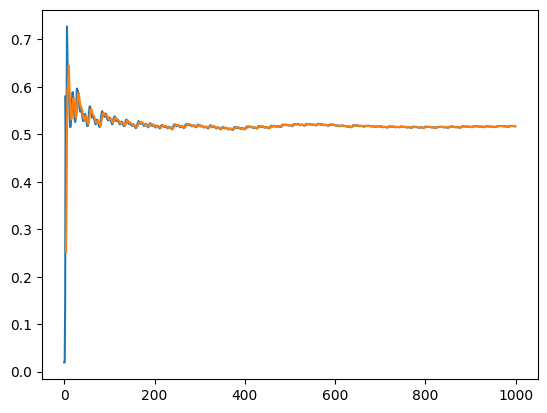

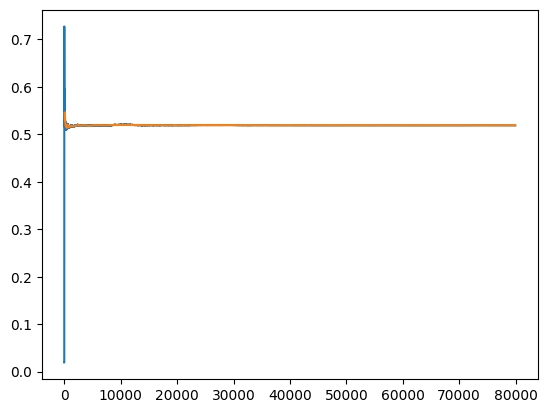

In [250]:
# Compute the mean of each row and all previous rows
raw_df['mean'] = raw_df['cost'].expanding().mean()

# Compute the standard deviation of each row and all previous rows
raw_df['std'] = raw_df['cost'].expanding().std()

# Solve for the coefficient of variation (CV) for each dataset
raw_df['CV'] = raw_df['std'] / raw_df['mean']

# Correct for Nan values by temporarily replacing them with next valid value
raw_df['CV'] = raw_df['CV'].fillna(method='bfill')

# Print the dataframe head and tail
print(raw_df.head())
print(raw_df.tail())

# Plot the CV for each row and plot trendline first 100 rows
plt.plot(raw_df['CV'].head(1000))
plt.plot(raw_df['CV'].head(1000).rolling(window=5).mean())
plt.show()

# Plot the CV for each row and plot trendline
plt.plot(raw_df['CV'])
plt.plot(raw_df['CV'].rolling(window=100).mean())
plt.show()

# Data post-processing
A new dataframe is created, containing the raw data post processed

In [251]:
# Creating copy of the raw dataframe
df = deepcopy(raw_df)

# --- Cost analysis
# Add column with difference between cost and ideal cost
df['total_cost_diff'] = df['cost'] - df['ideal_cost']

# Normalise the cost difference per agent with respect to the number of agents
df['cost_diff_per_agent'] = df['total_cost_diff'] / df['nb_agents']

# --- Run time multiplied by cost
df['run_time_per_cost_per_agent'] = (df['run_time'] / df['cost']) * df['nb_agents']

df['efficiency'] = 10**(-(df['run_time_per_cost_per_agent'] * df['cost_diff_per_agent']))

# Cleaning up the dataframe
del df['mean']
del df['std']
del df['CV']
# del df['cost']
del df['ideal_cost']
del df['total_cost_diff']

# Print resulting dataframe's head
print(df.head())

             test_name  start_type  cost  avg_deviation      run_time  \
0  instances/map_1.txt           0    36          1.364  4.000000e-03   
1  instances/map_1.txt           0    37          1.000  1.000000e-10   
2  instances/map_1.txt           0    28          1.036  1.000000e-10   
3  instances/map_1.txt           0    88          1.291  1.400000e-02   
4  instances/map_1.txt           0    64          2.269  7.000000e-03   

   nb_agents  cost_diff_per_agent  run_time_per_cost_per_agent  efficiency  
0          2             4.000000                 2.222222e-04    0.997955  
1          3             0.000000                 8.108108e-12    1.000000  
2          4             0.250000                 1.428571e-11    1.000000  
3          5             3.800000                 7.954545e-04    0.993064  
4          6             4.333333                 6.562500e-04    0.993473  


Furthermore, new dataframes with the data bucketed according to agent count, start type, and map type are created

## Bucketing by agent count

In [252]:
# Mean
df_mean_by_agent_count = df.groupby('nb_agents', as_index=False).mean()

# Cleanup dataframe
del df_mean_by_agent_count["start_type"]

print("--> Mean by agent count")
print(df_mean_by_agent_count.head())

# Create dataframe from raw data bucketed by agent count
df_std_by_agent_count = df.groupby('nb_agents', as_index=False).std()

# Cleanup dataframe
del df_std_by_agent_count["start_type"]

print("\n--> Standard deviation by agent count")
print(df_std_by_agent_count.head())

--> Mean by agent count
   nb_agents        cost  avg_deviation  run_time  cost_diff_per_agent  \
0          2   42.503556       1.114962  0.001040             0.912944   
1          3   65.882628       1.183822  0.002499             1.560409   
2          4   89.852532       1.260854  0.004612             2.126266   
3          5  114.480508       1.297769  0.007229             2.531677   
4          6  139.664803       1.335794  0.010496             2.925847   

   run_time_per_cost_per_agent  efficiency  
0                     0.000049    0.999669  
1                     0.000117    0.998988  
2                     0.000216    0.997768  
3                     0.000334    0.996387  
4                     0.000480    0.994333  

--> Standard deviation by agent count
   nb_agents       cost  avg_deviation  run_time  cost_diff_per_agent  \
0          2  13.604562       0.376087  0.001505             1.701305   
1          3  18.802743       0.415316  0.003127             2.051254   
2  

## Bucketing by map type

In [253]:
# Mean
df_mean_by_test_name = df.groupby('test_name', as_index=False).mean()

# Cleanup dataframe
del df_mean_by_test_name["start_type"]
del df_mean_by_test_name["nb_agents"]

print("--> Mean by test name")
print(df_mean_by_test_name)

# Standard deviation
df_std_by_test_name = df.groupby('test_name', as_index=False).std()

# Cleanup dataframe
del df_std_by_test_name["start_type"]
del df_std_by_test_name["nb_agents"]

print("\n--> Standard deviation by test name")
print(df_std_by_test_name)

--> Mean by test name
             test_name        cost  avg_deviation  run_time  \
0  instances/map_1.txt  131.847662       1.316277  0.014555   
1  instances/map_2.txt  140.476763       1.308614  0.010727   
2  instances/map_3.txt  147.566369       1.323021  0.011754   

   cost_diff_per_agent  run_time_per_cost_per_agent  efficiency  
0             2.824572                     0.000673    0.992073  
1             2.569454                     0.000489    0.993480  
2             2.854644                     0.000503    0.993101  

--> Standard deviation by test name
             test_name       cost  avg_deviation  run_time  \
0  instances/map_1.txt  68.953237       0.500975  0.017158   
1  instances/map_2.txt  72.269806       0.542804  0.014871   
2  instances/map_3.txt  75.708394       0.557811  0.014813   

   cost_diff_per_agent  run_time_per_cost_per_agent  efficiency  
0             2.481299                     0.000792    0.016593  
1             2.810363                     

## Bucketing by start type

In [254]:
# Mean
df_mean_by_start_type = df.groupby('start_type', as_index=False).mean()

# Cleanup dataframe
del df_mean_by_start_type["nb_agents"]

print("--> Mean by start type")
print(df_mean_by_start_type.head())

# Standard deviation
df_std_by_start_type = df.groupby('start_type', as_index=False).std()

# Cleanup dataframe
del df_std_by_start_type["nb_agents"]

print("\n--> Standard deviation by start type")
print(df_std_by_start_type.head())

--> Mean by start type
   start_type        cost  avg_deviation  run_time  cost_diff_per_agent  \
0           0  103.256007       1.816054  0.019647             5.165408   
1           1  157.571149       1.062038  0.008327             1.529334   
2           2  159.635154       1.061731  0.008933             1.515057   

   run_time_per_cost_per_agent  efficiency  
0                     0.001017    0.982303  
1                     0.000309    0.998308  
2                     0.000331    0.998217  

--> Standard deviation by start type
   start_type       cost  avg_deviation  run_time  cost_diff_per_agent  \
0           0  58.749268       0.683271  0.022235             3.429424   
1           1  71.823920       0.043463  0.008891             1.026783   
2           2  72.008423       0.044138  0.009131             1.033554   

   run_time_per_cost_per_agent  efficiency  
0                     0.000990    0.023967  
1                     0.000323    0.002827  
2                     0.00

# Statistical significance analysis

## Distribution analysis
First, an analysis of the dataset's various distributions is perfomed to get good inisght on the results' properties.

### Cost difference per agent
The cost difference per agent is first analysed. The first step is to obtain basic statistical properties on the entire dataset.

In [255]:
# Mean cost difference per agent
mean_cost_difference_per_agent = round(df['cost_diff_per_agent'].mean(), 3)
print(f'Mean cost difference per agent: {mean_cost_difference_per_agent}')

# Standard deviation of cost difference per agent
std_cost_diff_per_agent = round(df['cost_diff_per_agent'].std(), 3)
print(f'Std cost difference per agent: {std_cost_diff_per_agent}')

Mean cost difference per agent: 2.75
Std cost difference per agent: 2.763


The data split into various buckets is then considered, providing further insight on the dataset's statistical properties and basic relationship between key variables. The correlation between the various variables can notably be determined.

--> Mean cost difference per agent correlation with agent count
Correlation = 0.9888947459208303


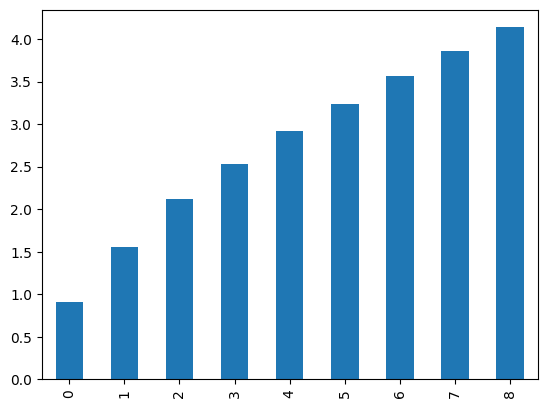

--> Std cost difference per agent correlation with agent count
Correlation = 0.963902433001586


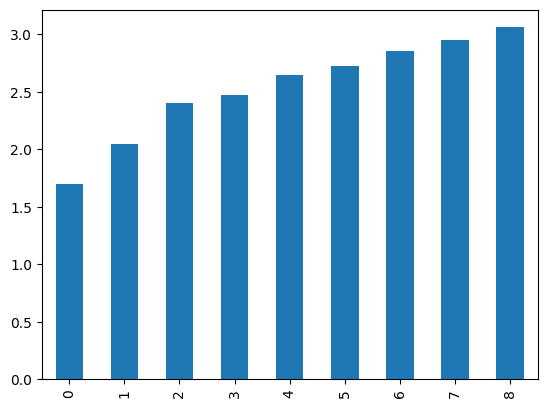

--> Cost difference per agent mean by test type (map type)


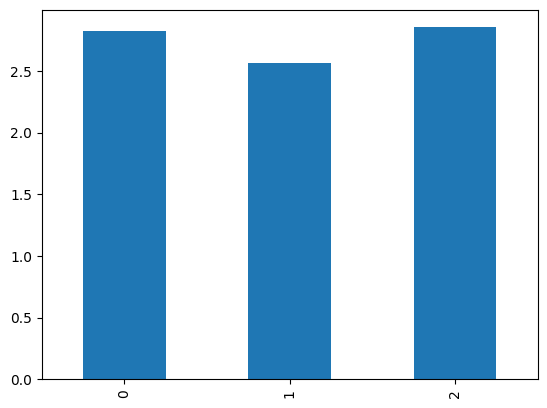

--> Cost difference per agent mean by start type


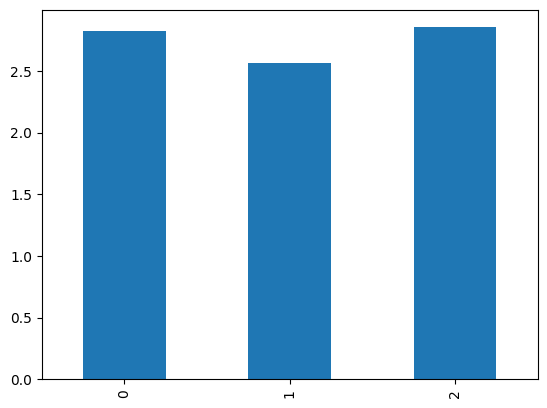

In [256]:
# --- Correlation with agent count
print("--> Mean cost difference per agent correlation with agent count")

# Solve for the correlation between the mean cost difference per agent and the agent count
correlation_mean_cost_difference_per_agent_and_agent_count = df_mean_by_agent_count['cost_diff_per_agent'].corr(df_mean_by_agent_count['nb_agents'])
print("Correlation =", correlation_mean_cost_difference_per_agent_and_agent_count)

# Plot the mean per agent count
df_mean_by_agent_count['cost_diff_per_agent'].plot(kind='bar')
plt.show()

print("--> Std cost difference per agent correlation with agent count")
# Solve for the correlation between the std cost difference per agent and the agent count
correlation_std_cost_difference_per_agent_and_agent_count = df_std_by_agent_count['cost_diff_per_agent'].corr(df_std_by_agent_count['nb_agents'])
print("Correlation =", correlation_std_cost_difference_per_agent_and_agent_count)

# Plot the mean per agent count
df_std_by_agent_count['cost_diff_per_agent'].plot(kind='bar')
plt.show()

# --- Correlation with test type
print("--> Cost difference per agent mean by test type (map type)")

# Plot the mean per agent count
df_mean_by_test_name['cost_diff_per_agent'].plot(kind='bar')
plt.show()

# --- Correlation with start type
print("--> Cost difference per agent mean by start type")

# Plot the mean per agent count
df_mean_by_test_name['cost_diff_per_agent'].plot(kind='bar')
plt.show()

In [257]:
# Mean run time
mean_average_deviation_per_agent = round(df['run_time'].mean(), 3)
print(f'Mean run time: {mean_cost_difference_per_agent}')

# Standard deviation of run time
std_average_deviation_per_agent = round(df['run_time'].std(), 3)
print(f'Std run time: {std_cost_diff_per_agent}')

Mean run time: 2.75
Std run time: 2.763


--> Mean run time correlation with agent count
Correlation = 0.9818928249999037


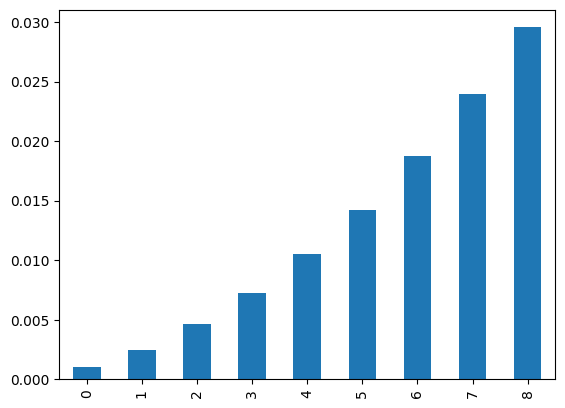

--> Std run time correlation with agent count
Correlation = 0.9921321484878894


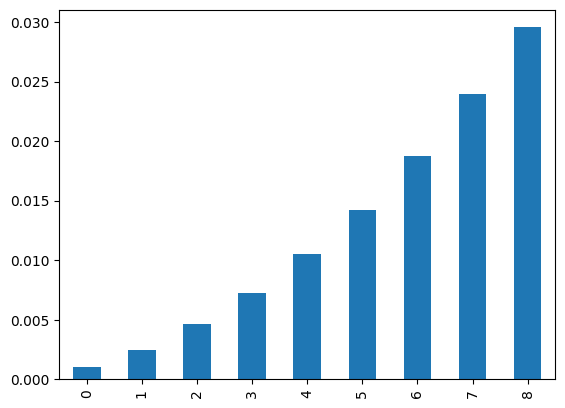

--> Average deviation mean by test type (map type)


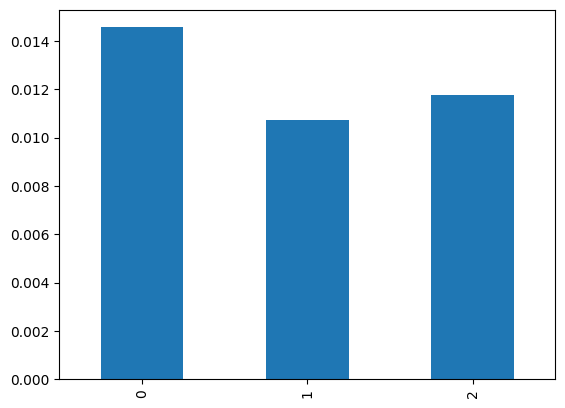

--> Average deviation mean by start type


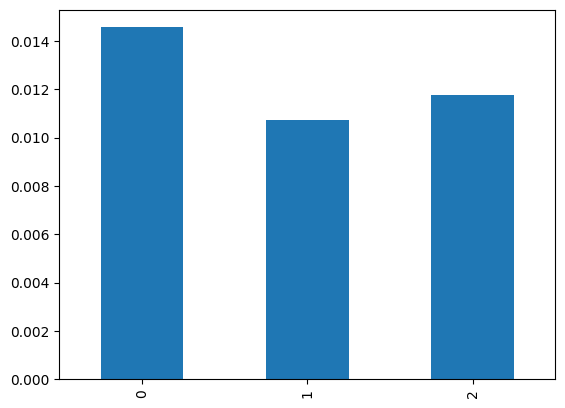

In [258]:
# --- Correlation with agent count
print("--> Mean run time correlation with agent count")
# Solve for the correlation between the mean run time and the agent count
correlation_mean_run_time_and_agent_count = df_mean_by_agent_count['run_time'].corr(df_mean_by_agent_count['nb_agents'])
print("Correlation =", correlation_mean_run_time_and_agent_count)

# Plot the mean per agent count
df_mean_by_agent_count['run_time'].plot(kind='bar')
plt.show()

print("--> Std run time correlation with agent count")
# Solve for the correlation between the std run time and the agent count
correlation_std_run_time_and_agent_count = df_std_by_agent_count['run_time'].corr(df_std_by_agent_count['nb_agents'])
print("Correlation =", correlation_std_run_time_and_agent_count)

# Plot the mean per agent count
df_mean_by_agent_count['run_time'].plot(kind='bar')
plt.show()

# --- Correlation with test type
print("--> Average deviation mean by test type (map type)")

# Plot the mean per agent count
df_mean_by_test_name['run_time'].plot(kind='bar')
plt.show()

# --- Correlation with start type
print("--> Average deviation mean by start type")

# Plot the mean per agent count
df_mean_by_test_name['run_time'].plot(kind='bar')
plt.show()

### Metrics cross-correlation
Finally, the two metrics are cross-correlated to determine their relationship.

In [259]:
# --- Correlation between mean cost difference per agent and run time
print("--> Mean cost difference per agent correlation with run time")
correlation_cost_difference_per_agent_and_run_time = df_mean_by_agent_count['cost_diff_per_agent'].corr(df_mean_by_agent_count['run_time'])
print("Correlation =", correlation_cost_difference_per_agent_and_run_time)

--> Mean cost difference per agent correlation with run time
Correlation = 0.9441635660778765


## Local Sensitivity analysis
A sensitivity analysis of the agent count is performed, providing insight on the impact of the parameter on cost difference mean, standard deviation, and on run time mean.
Given the integer nature of the agent count variable, and the constraints in time and processing power available to the team, it was decided to take as reference value an agent count of 6, and gather data on the +4 and -4 range.

   nb_agents        cost  avg_deviation  run_time  cost_diff_per_agent  \
0          2   42.503556       1.114962  0.001040             0.912944   
1          3   65.882628       1.183822  0.002499             1.560409   
2          4   89.852532       1.260854  0.004612             2.126266   
3          5  114.480508       1.297769  0.007229             2.531677   
4          6  139.664803       1.335794  0.010496             2.925847   
5          7  164.760738       1.369230  0.014221             3.243310   
6          8  190.809551       1.402950  0.018774             3.570100   
7          9  216.947942       1.430568  0.023943             3.856719   
8         10  243.096564       1.460362  0.029557             4.138987   

   run_time_per_cost_per_agent  efficiency         S+         S-  
0                     0.000049    0.999669   6.036463  -6.036463  
1                     0.000117    0.998988  13.577137 -13.577137  
2                     0.000216    0.997768  -9.616138   9.

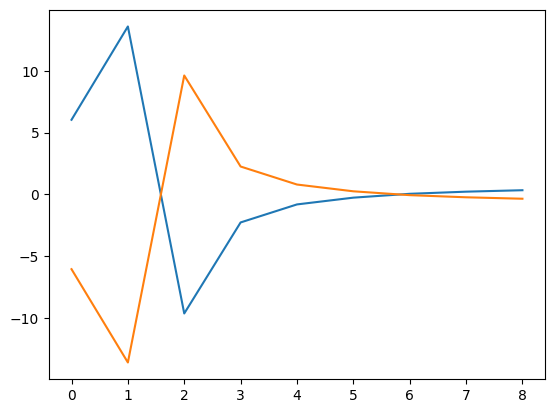

In [260]:
# --- Sensitivity analysis of means to agent count
reference_value = 3.5

# Positive
df_mean_by_agent_count["S+"] = (df_mean_by_agent_count['cost_diff_per_agent'] - reference_value) / ((df_mean_by_agent_count['nb_agents'] - reference_value) / reference_value)



# Negative
df_mean_by_agent_count["S-"] = (reference_value - df_mean_by_agent_count['cost_diff_per_agent']) / ((df_mean_by_agent_count['nb_agents'] - reference_value) / reference_value)

print(df_mean_by_agent_count)

# Plot the mean per agent count
df_mean_by_agent_count['S+'].plot(kind='line')
df_mean_by_agent_count['S-'].plot(kind='line')
plt.show()

# Results
The results obtained above are gathered here

In [266]:
# Distribution analysis (full set)

print("==========> Full dataset statistics")
table = [
    ["", "Mean", "Std"],
    ["Cost diff. per agent", mean_cost_difference_per_agent, std_cost_diff_per_agent],
    ["Run time", mean_average_deviation_per_agent, std_average_deviation_per_agent]
]

print(tabulate(
    table,
    headers="firstrow",
    tablefmt="presto"
))

print("\n==========> Bucketed dataset statistics")
# --- Run time multiplied by cost
df_mean_by_agent_count['run_time_per_cost_per_agent'] = (df_mean_by_agent_count['run_time'] / df_mean_by_agent_count['cost']) * df_mean_by_agent_count['nb_agents']
df_mean_by_agent_count['efficiency'] = 10**(-(df_mean_by_agent_count['run_time_per_cost_per_agent'] * df_mean_by_agent_count['cost_diff_per_agent']))

print("-----> Bucketed by agent count")
print("--> Mean by agent count")
print(df_mean_by_agent_count)
print("\n--> Standard deviation by agent count")
print(df_std_by_agent_count)

print("\n-----> Bucketed by test name")
print("--> Mean by test name")
print(df_mean_by_test_name)
print("\n--> Standard deviation by test name")
print(df_std_by_test_name)

print("\n-----> Bucketed by start type")
print("--> Mean by start type")
print(df_mean_by_start_type)
print("\n--> Standard deviation by start type")
print(df_std_by_start_type)

print("\n==========> Dataset correlation statistics")
print("> Correlation with agent count")
table = [
    ["", "Mean", "Std. deviation"],
    ["Cost diff. per agent", correlation_mean_cost_difference_per_agent_and_agent_count, correlation_std_cost_difference_per_agent_and_agent_count],
    ["Run time", correlation_mean_run_time_and_agent_count, correlation_std_run_time_and_agent_count]
]

print(tabulate(
    table,
    headers="firstrow",
    tablefmt="presto"
))

==========> Full dataset statistics
                      |   Mean |   Std
----------------------+--------+-------
 Cost diff. per agent |  2.75  | 2.763
 Run time             |  0.012 | 0.016

==========> Bucketed dataset statistics
-----> Bucketed by agent count
--> Mean by agent count
   nb_agents        cost  avg_deviation  run_time  cost_diff_per_agent  \
0          2   42.503556       1.114962  0.001040             0.912944   
1          3   65.882628       1.183822  0.002499             1.560409   
2          4   89.852532       1.260854  0.004612             2.126266   
3          5  114.480508       1.297769  0.007229             2.531677   
4          6  139.664803       1.335794  0.010496             2.925847   
5          7  164.760738       1.369230  0.014221             3.243310   
6          8  190.809551       1.402950  0.018774             3.570100   
7          9  216.947942       1.430568  0.023943             3.856719   
8         10  243.096564       1.460362  0.02